In [ ]:
#Retinal Disease Classification
#This notebook for multi-label classification

#Dataset: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification
#Build a model that further identifies the disease(s) amongst the images with unhealthy retinas

In [ ]:
#Download dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn import metrics
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet import ResNet50, ResNet152
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.applications.vgg19 import VGG19





In [ ]:
print(tensorflow.__version__)
print(keras.__version__)

2.18.0
3.7.0


In [ ]:
#Paths to Dataset

train_dir = path+ '/Training_Set/Training_Set/Training/'
test_dir = path+ '/Test_Set/Test_Set/Test/'
validation_dir = path+ '/Evaluation_Set/Evaluation_Set/Validation/'

train_labels = path+ '/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
test_labels = path+ '/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'
validation_labels = path+ '/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'


In [ ]:
#Load the labels
train_df = pd.read_csv(train_labels)
test_df = pd.read_csv(test_labels)
validation_df = pd.read_csv(validation_labels)

In [ ]:
train_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='None'>

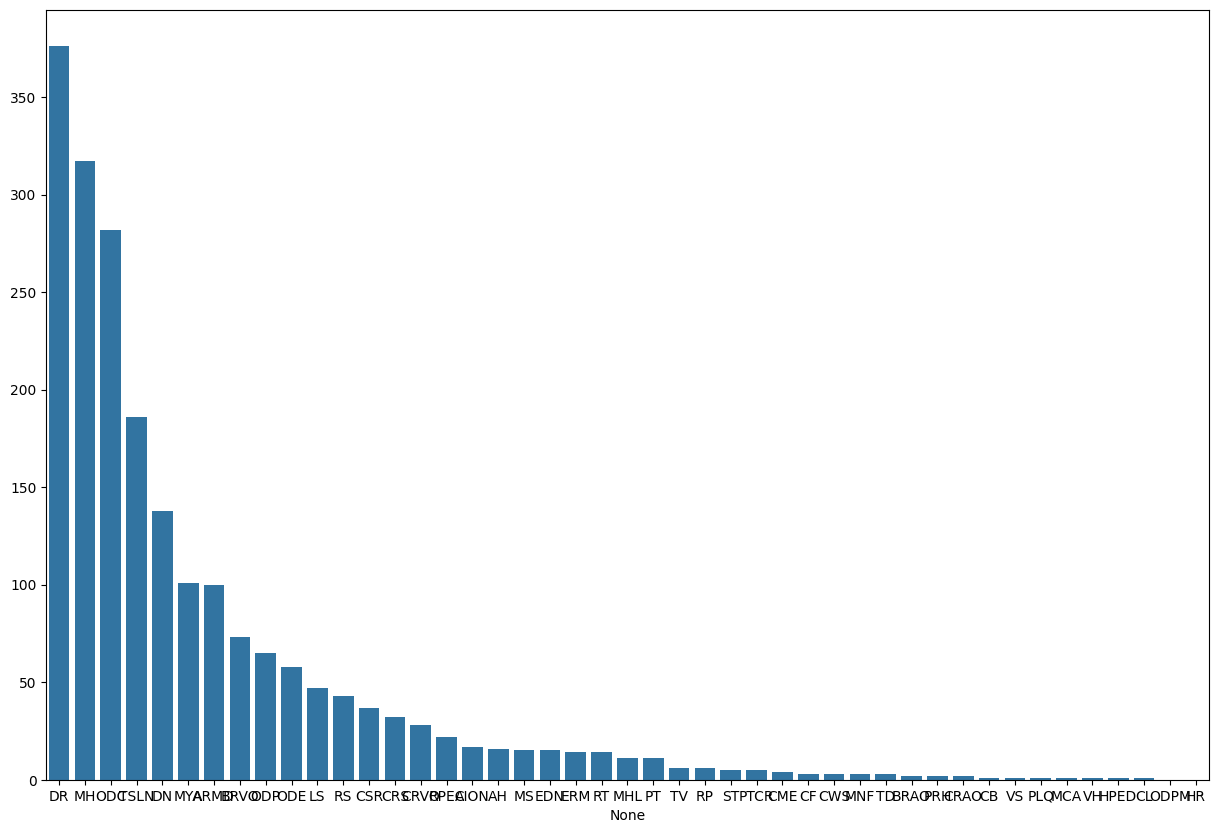

In [ ]:
#Expolartory Data Analysis
diseases = train_df.iloc[:, 2:].sum().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=diseases.index, y=diseases.values)


In [ ]:
diseases.head(10)

,0
DR,376
MH,317
ODC,282
TSLN,186
DN,138
MYA,101
ARMD,100
BRVO,73
ODP,65
ODE,58


In [ ]:
num_classes = diseases.count()
print("Number of classes:", num_classes)

Number of classes: 45


In [ ]:
#Select only the top 7 disease classes

diseases_s =list(diseases[0:7].index)
diseases_s

['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD']

In [ ]:
#Data preprocessing

def preprocessData(labels_df):
  labels_df = labels_df[labels_df['Disease_Risk']==1]
  return labels_df

def processData(image_dir, labels_df):
    images = []
    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return np.array(images)

def processLabels(labels_df, selected):
    y = np.array(labels_df[selected])

    return y




In [ ]:
train_df = preprocessData(train_df)
validation_df = preprocessData(validation_df)
test_df = preprocessData(test_df)

In [ ]:
Y_train = processLabels(train_df, diseases_s)
Y_val = processLabels(validation_df, diseases_s)
Y_test = processLabels(test_df, diseases_s)

In [ ]:
X_train = processData(train_dir, train_df)
X_val = processData(validation_dir, validation_df)
X_test = processData(test_dir, test_df)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(1519, 224, 224, 3) (1519, 7)
(506, 224, 224, 3) (506, 7)
(506, 224, 224, 3) (506, 7)


In [ ]:
#Normalize the images by dividing each pixel by 255 and apply data augmentation to the training data

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=20,
                                   #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
test_datagen = ImageDataGenerator(rescale = 1./255,)

In [ ]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)
test_datagen.fit(X_test)

In [ ]:
training_set =  train_datagen.flow(X_train,Y_train, batch_size = 8)
validation_set = val_datagen.flow(X_val,Y_val, batch_size = 8)
testing_set  =  test_datagen.flow(X_test,Y_test, batch_size = 8)


In [ ]:
def getModel(pretrained, input_shape):

    pretrained_model = pretrained(include_top=False, pooling = 'avg', input_shape=input_shape,weights='imagenet')
    #Make model not trainable for use in feature extraction
    for layer in pretrained_model.layers:
        layer.trainable = False
    #Get last layer
    last_output = pretrained_model.layers[-1].output
    # Flatten the output layer to 1 dimension
    res = Flatten()(last_output)
    # Add a fully connected layer with hidden units and ReLU activation
    res = Dense(256,activation="relu",kernel_regularizer=l2(0.01))(res)
    res = Dropout(0.5)(res)
    res = BatchNormalization()(res)
    res = Dense(7,activation="sigmoid")(res)

    # Configure and compile the model
    model = Model(pretrained_model.input, res)
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate = 0.0001),
                metrics=['AUC','binary_accuracy'])
    model.summary()
    return model

In [ ]:
EarlyStop = EarlyStopping(monitor='val_loss', mode= 'min',patience=20, verbose=1)

In [ ]:
#Train the model
input_shape = (224,224,3)
model = getModel(InceptionResNetV2, input_shape)
#Fit the model
history = model.fit(training_set,epochs = 50, validation_data = validation_set, verbose =1)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 54,733,031 (208.79 MB)

 Trainable params: 395,783 (1.51 MB)

 Non-trainable params: 54,337,248 (207.28 MB)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 89s 323ms/step - AUC: 0.5529 - binary_accuracy: 0.5267 - loss: 4.7662 - val_AUC: 0.6568 - val_binary_accuracy: 0.6894 - val_loss: 3.6853
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - AUC: 0.6518 - binary_accuracy: 0.6122 - loss: 3.5495 - val_AUC: 0.7025 - val_binary_accuracy: 0.7513 - val_loss: 2.9278
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - AUC: 0.6943 - binary_accuracy: 0.6864 - loss: 2.8297 - val_AUC: 0.7487 - val_binary_accuracy: 0.7609 - val_loss: 2.4545
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - AUC: 0.7000 - binary_accuracy: 0.7678 - loss: 2.3212 - val_AUC: 0.7542 - val_binary_accuracy: 0.8634 - val_loss: 2.0027
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 44s 151ms/step - AUC: 0.7174 - binary_accuracy: 0.8305 - loss: 1.9315 - val_AUC: 0.7314 - val_binary_accuracy: 0.8738 - val_loss: 1.6445
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - AUC: 0.7270 - binary_accuracy: 0.8542 - loss: 1.6364 - val

In [ ]:
model.save('retinal_model1.keras')

Text(0.5, 1.0, 'Training and validation AUC')

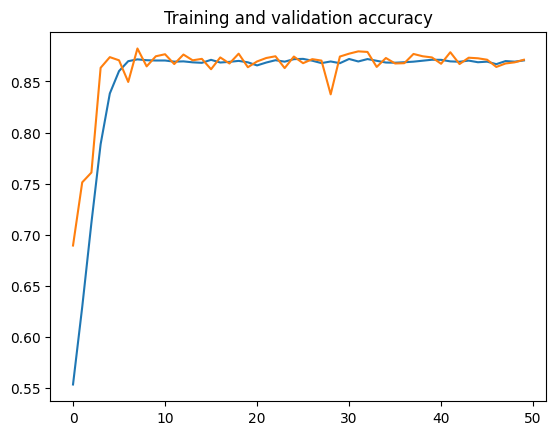

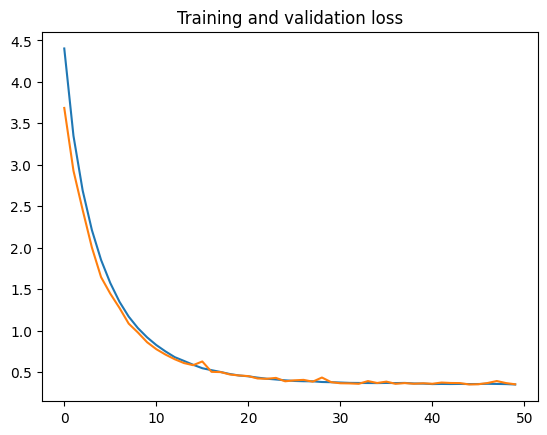

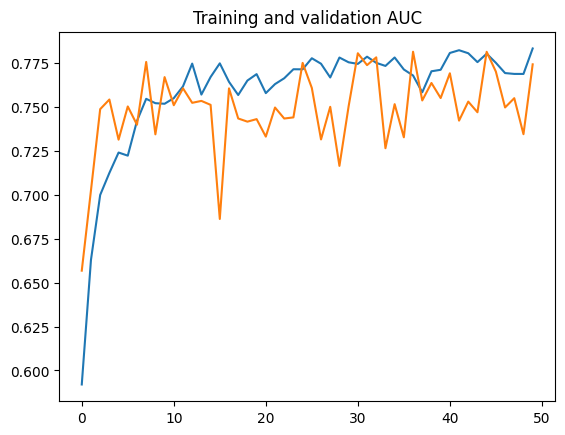

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# Retrieve a list of loss results on training and validation data
# sets for each validation epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve a list of AUC results on training and validation data
# sets for each validation epoch
auc = history.history['AUC']
val_auc = history.history['val_AUC']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.title('Training and validation AUC')

In [ ]:
#Test the model

predictions = model.predict(testing_set)

model.evaluate(testing_set, verbose=1)
print("Classification Report:")
print(metrics.classification_report(Y_test.argmax(axis=1),predictions.argmax(axis=1)))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - AUC: 0.7816 - binary_accuracy: 0.8754 - loss: 0.3456
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.23      0.31       256
           1       0.20      0.72      0.32       100
           2       0.11      0.08      0.09        52
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        22

    accuracy                           0.26       506
   macro avg       0.12      0.15      0.10       506
weighted avg       0.31      0.26      0.23       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

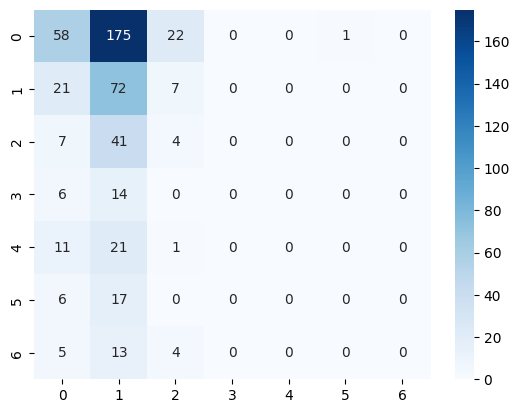

In [ ]:
#Generate confusion matrix
cm2 = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
#Visualize the confusion matrix
sns.heatmap(cm2,annot=True,fmt="d", cmap = 'Blues')